In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

La variable `year` permet de selectionner le fichier de données souhaité.

In [2]:
year = 2021

Ouverture du fichier souhaité.

In [3]:
df = pd.read_csv('valeursfoncieres_' + str(year) + '.csv',
                 sep="|",
                 header=0,
                 encoding='UTF-8',
                 low_memory=False)

On récupère les dimensions du dataframe pour analyser la quantité de donné supprrimé à chaque étape du Cleansing & Wrangling.

In [4]:
row_count = len(df.index)
col_count = len(df.columns)

#  1. Data Preparation - Cleansing & Wrangling

### Incompleteness

Suppression des colonnes et lignes avec des données manquantes.

In [5]:
# On commence par supprimer toutes les colonnes dont au moins la moitié des lignes sont vides
seuil = len(df.index) * 0.5
df = df.loc[:, df.count() > seuil]

# Nombre de colonnes suppimées.
print(str(col_count - len(df.columns)) + ' colonnes supprimées.')
col_count = len(df.columns)

22 colonnes supprimées.


In [6]:
# Supprimer les lignes du dataframe qui n'ont pas de valeur foncière
df = df.dropna(subset=['Valeur fonciere'])

# Nombre de lignes suppimées.
print(str(row_count - len(df.index)) + ' lignes supprimées.')
row_count = len(df.index)

32780 lignes supprimées.


In [7]:
# Supprimer les lignes du dataframe qui n'ont pas de donnée de surface

# Creation d'une variable (colonne) pour la surface du bien.
df['Surface'] = df[['Surface terrain','Surface reelle bati']].max(axis=1)
df = df[df['Surface'] > 0]

# Nombre de lignes suppimées.
print(str(row_count - len(df.index)) + ' lignes supprimées.')
row_count = len(df.index)

630818 lignes supprimées.


### Duplicates

In [8]:
df = df.drop_duplicates(keep='first')

# Nombre de lignes suppimées.
print(str(row_count - len(df.index)) + ' lignes supprimées.')
row_count = len(df.index)

206460 lignes supprimées.


### Data selection

Suppression des colonnes non pertinentes dans le cadre de l'analyse des données.

In [9]:
df = df.drop([
    'No disposition', 'No voie', 'Type de voie', 'Code voie', 'Code commune',
    'Section', 'No plan', 'Nombre de lots', 'Code type local',
    'Nombre pieces principales', 'Nature culture'
],
             axis=1)

# Nombre de colonnes suppimées.
print(str(col_count - len(df.columns)) + ' colonnes supprimées.')
col_count = len(df.columns)

10 colonnes supprimées.


### Data type conversions

Suite a l'impot des données dans le dataframe, certaines colonnes n'ont pas le type appropriés comme les valeurs foncières qui sont des `string` et non pas des `float`.

In [10]:
# Dates -> datetime
df['Date mutation'] = pd.to_datetime(df['Date mutation'], format='%d/%m/%Y')

# Valeur fonciere -> float
df.loc[:, 'Valeur fonciere'] = df['Valeur fonciere'].str.replace(',', '.')
df.loc[:, 'Valeur fonciere'] = df['Valeur fonciere'].astype(float)

# Code postal -> str
df.loc[:,['Code postal']] = df['Code postal'].astype('Int64')
df.loc[:,['Code postal']] = df['Code postal'].astype(str)

### Invalidity

In [11]:
# On élimine les lignes avec une valeur foncière négative
df = df.loc[df['Valeur fonciere'] >= 0]

# On élimine les lignes avec une surface négative
df = df.loc[df['Surface reelle bati'].notnull() >= 0]
df = df.loc[df['Surface terrain'].notnull() >= 0]

# Nombre de lignes suppimées.
print(str(row_count - len(df.index)) + ' lignes supprimées.')
row_count = len(df.index)

0 lignes supprimées.


### Inconsistency

In [12]:
code_lengths = df['Code departement'].astype(str).apply(lambda cd: len(cd)).values
df = df.loc[df['Code departement'] != df['Code postal'].str[code_lengths[0]]]

# Nombre de lignes suppimées.
print(str(row_count - len(df.index)) + ' lignes supprimées.')
row_count = len(df.index)

0 lignes supprimées.


In [13]:
#df.loc[:, 'Code departement'] = df['Code departement'].str.replace('[A-Za-z\.]', '')

### Aggregation

In [14]:
# Creation d'une variable (colonne) pour le prix au mètre carré.
df['Prix m2'] = df['Valeur fonciere'] / df['Surface']

# Nombre de colonnes ajoutées.
print(str(abs(col_count - len(df.columns))) + ' colonnes ajoutées.')
col_count = len(df.columns)

1 colonnes ajoutées.


### Filtration

On crée deux filtres pour l'analyse des données par département et par mois.

In [15]:
def select_month(df, m):
    return df[pd.DatetimeIndex(df['Date mutation']).month == m]

def select_dep(df, dep):
    return df.loc[df['Code departement'] == dep]

In [16]:
# Création de 10 intervalles pour surface terrain --> stocké dans la colonne Surface terrain Intervalle

# Définiton de la taille des intervalles
I = (df["Surface terrain"].max()) / 10
print(I)

df["Surface terrain Intervalle"] = pd.cut(df["Surface terrain"],
                                          bins=[
                                              df["Surface terrain"].min(), I,
                                              I * 2, I * 3, I * 4, I * 5,
                                              I * 6, I * 7, I * 8, I * 9,
                                              I * 10
                                          ],
                                          include_lowest=True)

296732.9


In [17]:
df["Surface reelle bati intervalle"] = pd.qcut(
    df["Surface reelle bati"],
    4,
    labels=["Petit", "Moyen", "Grand", "Tres grand"])

## Outliers

In [18]:
def remove_outliers(df, col):
    Q3 = np.nanquantile(df[col], 0.75)
    Q1 = np.nanquantile(df[col], 0.25)

    IQR = Q3 - Q1

    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR

    upper = df[df[col] > lower_range]
    lower = upper[upper[col] < upper_range]

    return lower

In [19]:
for col in ['Valeur fonciere', 'Surface', 'Prix m2']:
    df = remove_outliers(df, col)

# Nombre de lignes supprimées.
print(str(row_count - len(df.index)) + ' lignes supprimées.')
row_count = len(df.index)

716237 lignes supprimées.


## Normalisation

On ajoute unee colonne contenant les valeurs foncieres normalisées.

In [20]:
Min = df['Valeur fonciere'].min()
Max = df['Valeur fonciere'].max()

df['Valeur fonciere normalisee'] = (df['Valeur fonciere'] - Min)/(Max - Min)

In [21]:
df

,Date mutation,Nature mutation,Valeur fonciere,Voie,Code postal,Commune,Code departement,Type local,Surface reelle bati,Surface terrain,Surface,Prix m2,Surface terrain Intervalle,Surface reelle bati intervalle,Valeur fonciere normalisee
0,2021-01-05,Vente,185000.0,DE VOGELAS,1370,VAL-REVERMONT,01,Maison,97.0,2410.0,2410.0,76.763485,"(-0.001, 296732.9]",Grand,0.302549
1,2021-01-05,Vente,185000.0,DE VOGELAS,1370,VAL-REVERMONT,01,Dépendance,0.0,2410.0,2410.0,76.763485,"(-0.001, 296732.9]",Petit,0.302549
2,2021-01-06,Vente,10.0,ROUGEMONT,1290,BEY,01,NaN,NaN,530.0,530.0,0.018868,"(-0.001, 296732.9]",NaN,0.000016
3,2021-01-04,Vente,204332.0,DES ECUREUILS,1310,BUELLAS,01,Maison,88.0,866.0,866.0,235.949192,"(-0.001, 296732.9]",Grand,0.334165
4,2021-01-06,Vente,320000.0,DE CERTINES,1250,MONTAGNAT,01,Maison,168.0,1426.0,1426.0,224.403927,"(-0.001, 296732.9]",Tres grand,0.523329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3379110,2021-02-11,Vente,372000.0,DU MAIL,75002,PARIS 02,75,Local industriel. commercial ou assimilé,93.0,NaN,93.0,4000.000000,NaN,Grand,0.608370
3379124,2021-03-01,Vente,190000.0,D ABOUKIR,75002,PARIS 02,75,Local industriel. commercial ou assimilé,77.0,NaN,77.0,2467.532468,NaN,Grand,0.310726
3379156,2021-03-08,Vente,100000.0,ST LOUIS EN L ILE,75004,PARIS 04,75,Appartement,29.0,NaN,29.0,3448.275862,NaN,Petit,0.163540
3379207,2021-03-08,Vente,220000.0,SAINT-DENIS,75002,PARIS 02,75,Local industriel. commercial ou assimilé,197.0,NaN,197.0,1116.751269,NaN,Tres grand,0.359789


# 2. Data visualisation

In [22]:
df.describe()

,Valeur fonciere,Surface reelle bati,Surface terrain,Surface,Prix m2,Valeur fonciere normalisee
count,1.792937e+06,1.061830e+06,1.524873e+06,1.792937e+06,1.792937e+06,1.792937e+06
mean,1.602489e+05,7.790902e+01,6.444075e+02,5.592951e+02,8.183199e+02,2.620714e-01
std,1.318178e+05,8.495364e+01,5.728973e+02,5.672638e+02,1.007751e+03,2.155754e-01
min,1.500000e-01,0.000000e+00,0.000000e+00,1.000000e+00,5.753740e-05,0.000000e+00
25%,5.700000e+04,4.000000e+01,2.140000e+02,1.130000e+02,1.216028e+02,9.321776e-02
50%,1.350000e+05,7.300000e+01,4.980000e+02,3.910000e+02,3.795181e+02,2.207792e-01
75%,2.300000e+05,1.020000e+02,8.860000e+02,7.860000e+02,1.118189e+03,3.761426e-01
max,6.114700e+05,2.620000e+03,2.625000e+03,2.625000e+03,4.216216e+03,1.000000e+00


### Proportion variables qualitatives

In [23]:
def draw_boxplot(df, col):
    graph = df[col].value_counts().to_frame()
    graph.columns = ['Nombre']
    graph['Nom'] = graph.index
    graph.index = range(len(graph))
    cutoff = graph['Nombre'].sum() * 0.025
    graph.loc[graph['Nombre'] < cutoff, 'Nom'] = 'Autres'
    graph = graph.groupby('Nom')['Nombre'].sum().reset_index()
    graph.plot.pie(y='Nombre',
                   labels=graph['Nom'],
                   autopct='%1.2f%%',
                   pctdistance=0.5,
                   labeldistance=1.2,
                   center=(0, 0),
                   title="Répartition de la variable '" + str(col) + "'",
                   figsize=(5, 5),
                   radius=1,
                   legend=False,
                   ylabel='')

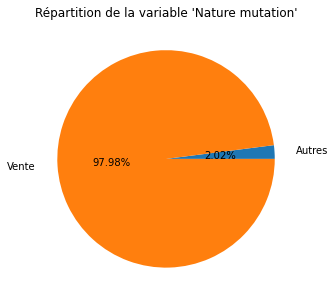

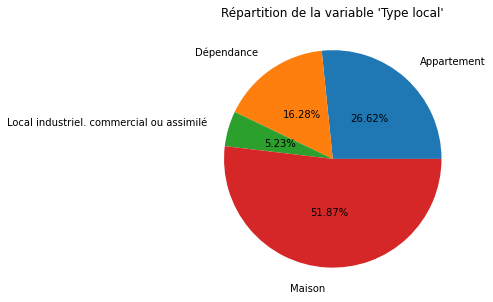

In [24]:
draw_boxplot(df, 'Nature mutation')
draw_boxplot(df, 'Type local')

### Distributions variables

Text(0.5, 1.0, 'Distribution des surfaces')

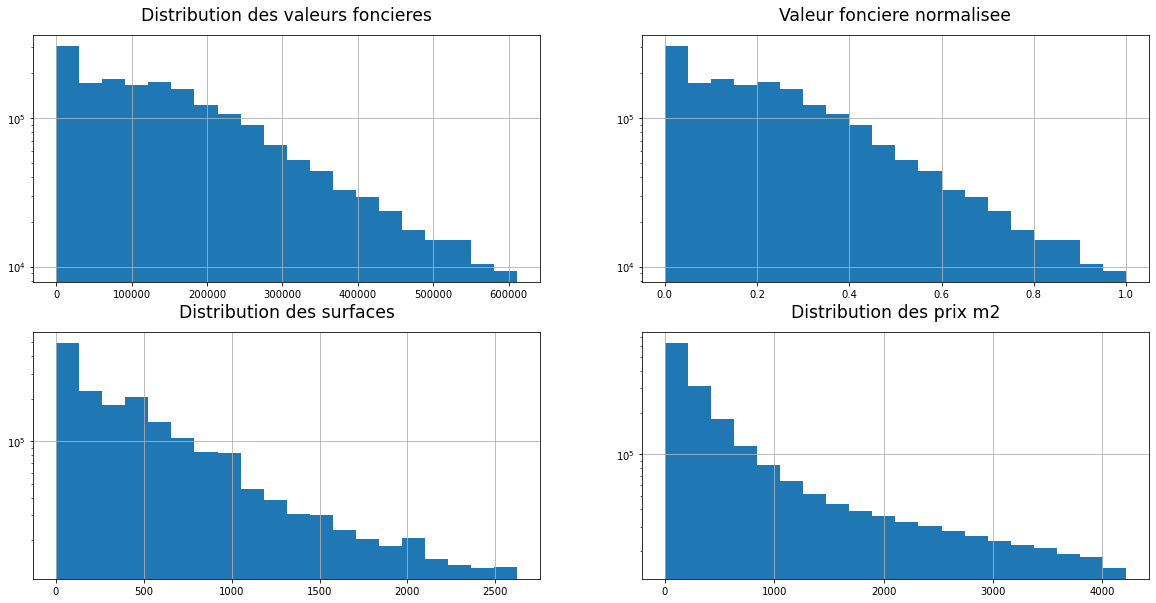

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=[20,10])

# Histogramme de la distribution des valeurs foncieres
df['Valeur fonciere'].hist(bins=20, log=True, ax=ax1[0])
ax1[0].set_title('Distribution des valeurs foncieres', fontsize="xx-large", pad=15)

# Histogramme de la distribution des surfaces
df['Valeur fonciere normalisee'].hist(bins=20, log=True, ax=ax1[1])
ax1[1].set_title('Valeur fonciere normalisee', fontsize="xx-large", pad=15)

# Histogramme de la distribution des prix au m2
df['Prix m2'].hist(bins=20, log=True, ax=ax2[1])
ax2[1].set_title('Distribution des prix m2', fontsize="xx-large", pad=15)

# Histogramme de la distribution des surfaces
df['Surface'].hist(bins=20, log=True, ax=ax2[0])
ax2[0].set_title('Distribution des surfaces', fontsize="xx-large", pad=15)

<AxesSubplot:>

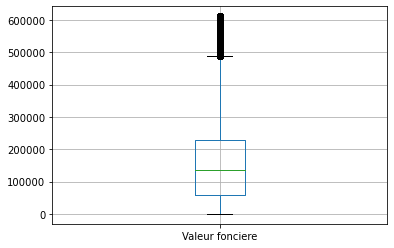

In [26]:
df.boxplot(column=['Valeur fonciere'])

### Volume transactions mensuel

<AxesSubplot:xlabel='Date mutation'>

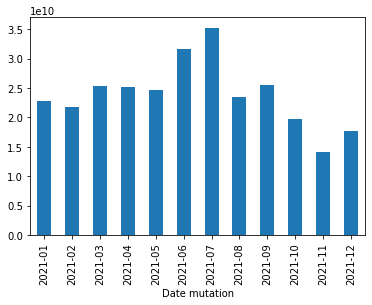

In [27]:
df1 = df.groupby(df['Date mutation'].dt.to_period('M')).sum()
df1 = df1.resample('M').asfreq().fillna(0)
df1['Valeur fonciere'].plot(kind='bar')

### Relation between variables

<AxesSubplot:xlabel='Valeur fonciere', ylabel='Surface reelle bati'>

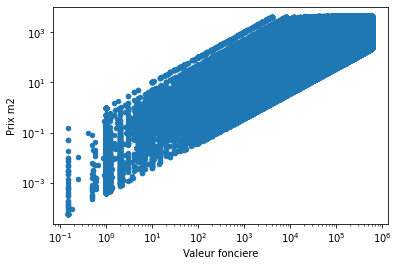

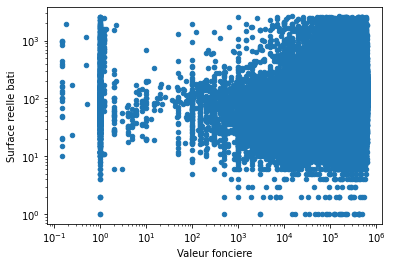

In [28]:
df.plot('Valeur fonciere','Prix m2', kind='scatter', logx=True, logy=True)
df.plot('Valeur fonciere','Surface reelle bati', kind='scatter', logx=True, logy=True)

### Classement selon les prix m2

In [29]:
df = df.dropna(subset=['Surface terrain'])
df = df.dropna(subset=['Surface reelle bati'])

df = df[df['Surface terrain']!=0]
df = df[df['Surface reelle bati']!=0]

df.groupby(df['Commune']).mean().sort_values('Prix m2')['Prix m2'].to_frame()

,Prix m2
Commune,
ROUVROIS SUR OTHAIN,0.050725
CESSE,0.763359
FRAIN,0.934579
CHEVROCHES,1.126245
SAINT-GEORGES-DES-AGOUTS,1.234568
...,...
BAUME (LA),3644.871795
LYON 7EME,3692.592593
PIERREFITTE-EN-AUGE,3808.703704


In [30]:
df.groupby(df['Code departement']).mean().sort_values('Prix m2')['Prix m2'].to_frame()

,Prix m2
Code departement,
23,259.328095
58,287.836653
70,291.076631
36,292.678725
52,301.601045
...,...
78,1083.863190
95,1171.887550
93,1190.821566


In [31]:
df.groupby(df['Type local']).mean().sort_values('Prix m2')['Prix m2'].to_frame()

,Prix m2
Type local,
Maison,580.248029
Local industriel. commercial ou assimilé,672.266625
Appartement,1054.636962


### Classement départements par nombre de transactions

In [32]:
df['Code departement'].value_counts()

59     36167
33     19843
44     18849
77     17230
62     16415
       ...  
05       534
971      476
2A       402
75       315
2B       197
Name: Code departement, Length: 97, dtype: int64